# Skin Lesion Classifier

A multiclass classifier that predicts different kinds of skin lesions from photographs.<br />
<br />
The dataset used for training the model is "HAM10000"<br />
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

The model is created using the fastai library where transfer learning was used with a pretrained resnet34 model.<br />
http://fast.ai

The resnet34 model was pretrained with the Imagenet dataset<br />
http://www.image-net.org/


In [21]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import matplotlib.pyplot as plt


In [22]:
# Paths to csv and images
path_img= str(Path().absolute()) + '\\data\\img'
path_csv = str(Path().absolute()) +'\\data\\HAM10000_metadata.csv'
path_csv

'C:\\FASTAI\\projects\\SKinDetector\\data\\HAM10000_metadata.csv'

In [23]:
# Read the metadata csv, using the filenames as index
df=pd.read_csv(path_csv)#.set_index('image_id')


In [24]:
#Makes sure GPU is available
import torch
torch.cuda.is_available()

True

In [25]:
np.random.seed(77)

In [26]:
# Take a look at the data
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [27]:
#Make the prediction classes easier to read
lesion_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [28]:
#Create new columns for numbered labels and description
df.dx=df.dx.astype('category',copy=True)
df['labels']=df.dx.cat.codes 
df['lesion']= df.dx.map(lesion_dict)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,labels,lesion
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,Benign keratosis


In [29]:
#List number of different prediction classes
df.lesion.value_counts()

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64

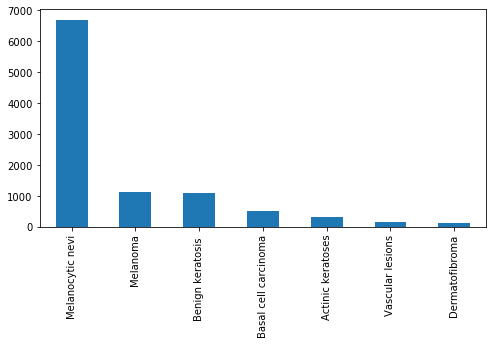

In [30]:
df['lesion'].value_counts().plot(kind='bar', figsize= (8, 4))

In [31]:
#Set transformation
tfms = get_transforms(flip_vert=True)

In [32]:
#Create imageList
temp_df = pd.DataFrame([df['image_id'], df['lesion']]).T
data = ImageList.from_df(temp_df, path_img, suffix='.jpg')

In [33]:
#Create Databunch from ImageList
data = (data
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df()
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=450)
        #Data augmentation? -> use tfms with a size of 128
        .databunch(bs = 16))                          
        #Finally -> use the defaults for conversion to databunch

To avoid an error when using PyTorch the targs tensor needs to be converted to long.


In [34]:
def new_error_rate(input:Tensor, targs:Tensor)->Rank0Tensor:
    return 1 - new_accuracy(input, targs)



def new_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1).long()          #<----    Added .long()
    return (input==targs).float().mean()


In [48]:
#Create a pretrained resnet34 model
learn = cnn_learner(data, models.resnet34, metrics=new_error_rate)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


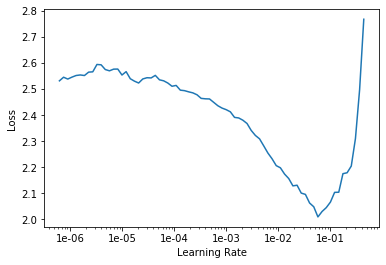

In [18]:
learn.recorder.plot()

In [36]:
lr = 1e-02
learn.fit_one_cycle(6, slice(lr))

epoch,train_loss,valid_loss,new_error_rate,time
0,0.851222,0.741375,0.287069,04:14
1,0.743757,0.738705,0.301048,04:14
2,0.657341,0.553081,0.195207,04:16
3,0.569036,0.632766,0.225162,04:18
4,0.554532,0.536788,0.189216,04:17
5,0.518296,0.580776,0.182227,04:16


In [37]:
learn.save('cycle1-5')

In [38]:
learn.unfreeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


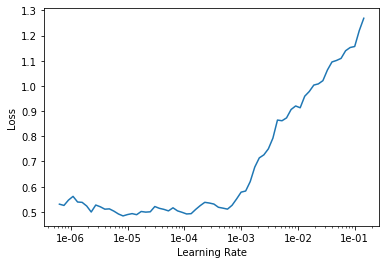

In [96]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(2, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,new_error_rate,time
0,0.632606,0.977624,0.210684,04:21
1,0.453607,0.493301,0.181228,04:20


In [43]:
learn.save('final')

In [44]:
interp = ClassificationInterpretation.from_learner(learn)

In [45]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

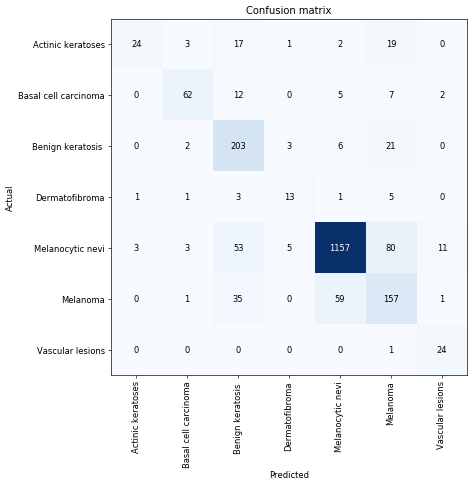

In [46]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [47]:
interp.confusion_matrix()

array([[  24,    3,   17,    1,    2,   19,    0],
       [   0,   62,   12,    0,    5,    7,    2],
       [   0,    2,  203,    3,    6,   21,    0],
       [   1,    1,    3,   13,    1,    5,    0],
       [   3,    3,   53,    5, 1157,   80,   11],
       [   0,    1,   35,    0,   59,  157,    1],
       [   0,    0,    0,    0,    0,    1,   24]], dtype=int64)